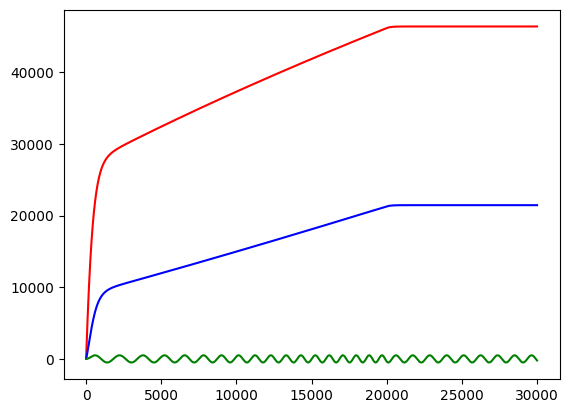

In [206]:
import matplotlib.pyplot as plt
import numpy as np
import math

M_PI = 3.14159265358979

propThrustFactor_x = -0.0024
propThrustFactor_y = -0.112
propThrustFactor_z = 7.5
maxRPM = 24000
propA = 6.7e-09
propTorqFactor = 0.009
#propInertia = 4.13e-06
propInertia = 1.23e-06

motorKV = 3600
motorR = 0.26
motorI0 = 0.75

vbat = 16.0

def oscillation1f(amplitude, frequencyHz, timeSec):
  phaseShift = 0.0
  return amplitude * math.sin((2.0 * M_PI * frequencyHz * timeSec  + phaseShift)  * (180.0 / M_PI))

def rpmToHz(rpm):
  return rpm * 0.016666666666


def prop_thrust(rpm, vel):
  # max thrust vs velocity:
  propF = propThrustFactor_x * vel * vel + propThrustFactor_y * vel + propThrustFactor_z
  propF = max(0.0, propF)

  # thrust vs rpm (and max thrust)
  b = (propF - propA * maxRPM * maxRPM) / maxRPM
  result = b * rpm + propA * rpm * rpm

  return  max(result, 0.0)

def prop_torque(rpm, vel):
  return prop_thrust(rpm, vel) * propTorqFactor

def motor_torque(volts, rpm):
  current = (volts - (rpm / motorKV)) / motorR

  if (current > 0):
    current = max(0.0, current - motorI0)
  elif (current < 0):
    current = min(0.0, current + motorI0)
  return current * 60 / (motorKV * 2.0 * M_PI)

def clamp(x, min, max):
  if (x < min):
    return min
  if (x > max):
    return max
  return x

rpmList = []
pthrustList = []
freqList = []

current_rpm = 0

for t in range(0, 30000):
  freq = 20e3
  DELTA = 1e6 / freq
  dt = DELTA / 1e6

  factor = t / freq
  if (factor > 1.0):
    factor = 1.0
  pwm  = factor * 1000 + 1000

  if (pwm > 2000):
    pwm = 2000

  rpm = current_rpm

  volts = float(pwm) / 1000.0 * float(vbat)
  
  mtorque = motor_torque(volts, rpm)

  ptorque = prop_torque(rpm, 0)
  nettorque = mtorque - ptorque
  domega = nettorque / propInertia

  drpm = (domega * dt) * 60.0 / (2.0 * M_PI)

  maxdrpm = abs(volts * motorKV - rpm)
  rpm += clamp(drpm, -maxdrpm, maxdrpm)

  pthrust= prop_thrust(rpm, 0)

  current_rpm = rpm

  rpmList.append(rpm)
  pthrustList.append(1000 * pthrust)
  freqList.append(oscillation1f(500, rpmToHz(rpm) / 50, t * 1e-6))
  


plt.plot(np.array(rpmList), color = "r")
plt.plot(np.array(pthrustList), color = "b")
plt.plot(np.array(freqList), color = "g")

plt.show() 